In [93]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [245]:
import cv2
from PIL import Image,ImageOps,ImageEnhance
from io import BytesIO
from pokedex.augmentation import get_augment_data
from pokedex.text_detection import ocr_text,get_id_coords,get_pokeid,ocr_preprocessor,clean_pokeid
from pokedex import SETINFO
from pokedex.edges.deformer import deform_card
from pokedex.prediction import card_ocr_crop

import numpy as np
from matplotlib import pyplot as plt

import pytesseract
import pyocr

from transformers import AutoProcessor
import torch

import re
import requests

import pandas as pd

In [3]:
path_name_left = '/Users/emiliasato/code/AoesJP/project_pokereader/raw_data/dict_reduceddataset_left.json'
path_name_right = '/Users/emiliasato/code/AoesJP/project_pokereader/raw_data/dict_reduceddataset_right.json'
augmented_df_left = get_augment_data(path_name_left)
augmented_df_right = get_augment_data(path_name_right)

In [70]:
i = 26
img = augmented_df_left.loc[i,'corner']
set_id = augmented_df_left.loc[i,'set_id']
plt.imshow(ocr_preprocessor(img,set_id),cmap='gray')
print(get_pokeid(img,set_id),set_id) 

error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.simd_helpers.hpp:92: error: (-2:Unspecified error) in function 'cv::impl::(anonymous namespace)::CvtHelper<cv::impl::(anonymous namespace)::Set<3, 4, -1>, cv::impl::(anonymous namespace)::Set<1, -1, -1>, cv::impl::(anonymous namespace)::Set<0, 2, 5>, cv::impl::(anonymous namespace)::NONE>::CvtHelper(cv::InputArray, cv::OutputArray, int) [VScn = cv::impl::(anonymous namespace)::Set<3, 4, -1>, VDcn = cv::impl::(anonymous namespace)::Set<1, -1, -1>, VDepth = cv::impl::(anonymous namespace)::Set<0, 2, 5>, sizePolicy = cv::impl::(anonymous namespace)::NONE]'
> Invalid number of channels in input image:
>     'VScn::contains(scn)'
> where
>     'scn' is 1


In [54]:
set_df

,0,1,2,3,4
0,dv1,21,Dragon Vault,right,20
1,swsh9,186,Brilliant Stars,left,172
2,swsh45,73,Shining Fates,left,72
3,swsh6,233,Chilling Reign,left,198
4,swsh12pt5,160,Crown Zenith,left,159
5,xy1,146,XY,right,146
6,xy2,110,Flashfire,right,106
7,xy3,114,Furious Fists,right,111
8,g1,117,Generations,right,83
9,xy4,124,Phantom Forces,right,119


In [81]:
SETINFO
set_id = 'sv3'
SETINFO[SETINFO[:, 0] == set_id][0,4]

'197'

In [82]:
def extract_number_before_slash_or_cardtotal(text, set_id):

    sequence = SETINFO[SETINFO[:, 0] == set_id][0,4]
    #sequence = sequence_row['sequence'].values[0]
    
    # Remove all special characters except digits, slash, and the specific sequence
    cleaned_text = re.sub(r'[^0-9/]', '', text)

    # Check if a slash exists in the cleaned text
    if '/' in cleaned_text:
        # Regular expression to find numbers before a slash
        match = re.search(r'(\d+)(?=/)', cleaned_text)
        if match:
            return match.group(1)
        else:
            # If no digits are found before the slash, return an empty string
            return ''
    else:
        # Check if the sequence exists in the cleaned text and is followed by a non-digit or end of string
        pattern = rf'(\d+)(?={sequence}(?!\d))'
        match = re.search(pattern, cleaned_text)
        if match:
            return match.group(1)
        else:
            # If no slash and no sequence, extract all digits in the cleaned text
            number_match = re.search(r'\d+', cleaned_text)
            if number_match:
                return number_match.group(0)
            else:
                # If no digits are found, return an empty string or handle it as needed
                return ''
text = '202020'
set_id = 'dv1'
extract_number_before_condition(text, 'dv1')
#set_df[4][set_df[0] == f'{set_id}'][0]

'2020'

In [4]:
def extract_number_before_slash(text):
    # Remove all special characters except digits and slash
    cleaned_text = re.sub(r'[^0-9/]', '', text)
    
    # Regular expression to find numbers before a slash
    match = re.search(r'(\d+)(?=/)', cleaned_text)
    
    # If a match is found, return the number before the slash
    if match:
        return match.group(1)
    else:
        # If no slash is found, extract all dig,its in the cleaned text
        number_match = re.search(r'\d+', cleaned_text)
        if number_match:
            return number_match.group(0)
        else:
            # If no digits are found, return an empty string or handle it as needed
            return ''
            
texts = ["123/456", "789", "10/20", "35a/45b", "no numbers here", "000/111"]
cleaned_numbers = [extract_number_before_slash(text) for text in texts]
cleaned_numbers

['123', '789', '10', '35', '', '000']

In [229]:
text = '7'
set_id = 'swsh9'

clean_pokeid(text,set_id)

'1'

In [96]:
text = '@7690/89'
set_id = 'swsh9'

def clean_pokeid(pokeid,set_id)
    if ' ' in text:
        text = text.split(' ', 1)[1]
    if '/' in text:
        text = extract_number_before_slash(text)
    text = re.sub(r'[^A-Za-z0-9]', '', text)
    if set_id == 'dv1':
        if len(text) > 2:
            text =  text[:2]
        if text[0] == '7':
            text = '1' + text[1:]
    
    elif set_id == 'swsh9':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
            
    elif set_id == 'swsh45':
        if len(text) > 2:
            text =  text[:2]
        if text[0] == '7':
            text = '1' + text[1:]
    
    elif set_id == 'swsh6':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    
    elif set_id == 'swsh12pt5':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    
    elif set_id == 'xy1':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'xy2':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'xy3':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'g1':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'xy4':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'xy6':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'xy7':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'dp1':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'dp2':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'sm4':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'swsh10':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'sv4':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'sv3pt5':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]
    elif set_id == 'sv3':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]      
    elif set_id == 'sv2':
        if len(text) > 3:
            text =  text[:3]
        if text[0] == '7':
            text = '1' + text[1:]   
    return text
print("after fourth function",text)  
        


SyntaxError: expected ':' (2921942437.py, line 4)

In [52]:
set_df = pd.DataFrame(SETINFO)
set_df[4][set_df[0] == 'dv1'][0]

'20'

In [15]:
augmented_df_left.loc[400,'set_id']

'swsh12pt5'

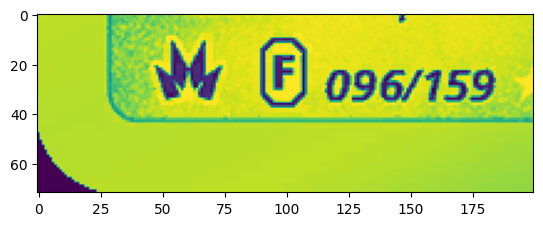

In [20]:
plt.imshow(augmented_df_left.loc[400,'corner'])

In [6]:
def preproc_clean(data: list):
    _ = np.array(data)
    return np.expand_dims(_, axis=2).astype("uint8")

def preproc_aug(data: list):
    _ = np.array(data)
    return np.squeeze(_.astype("uint8"), axis=0)

def to_rgb(img: np.ndarray):
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

sm4
sm4
CPU times: user 40.6 ms, sys: 30.8 ms, total: 71.4 ms
Wall time: 424 ms


'78/1114'

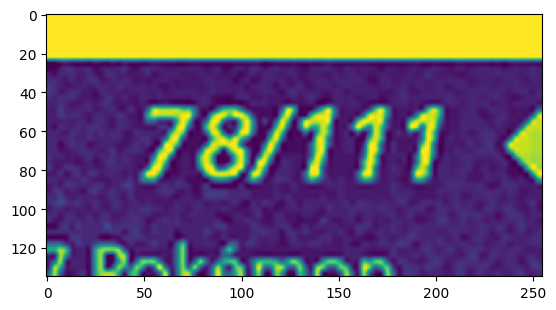

In [618]:
%%time
def ocr_preprocessor(img,set_id):
    img = preproc_clean(img).squeeze()
    img= Image.fromarray(img)
    side_offset = 10 #we need to fine tune this
    a,b,c,d = get_id_coords(set_id)

    img = img.crop((a - side_offset, b-side_offset, c+side_offset, d+ side_offset))
    img_contrast = img.resize((img.width * 3, img.height * 3), Image.BICUBIC)
    contrast_enhancer = ImageEnhance.Contrast(img_contrast)
    img_contrast = contrast_enhancer.enhance(1)
    median = np.median(img_contrast)
        
    mean = np.mean(img_contrast)
        
    im_offset = np.clip(img_contrast, 0, 255).astype("uint8")
    im_offset = Image.fromarray(im_offset)
        
    im_offset = ImageOps.invert(im_offset)
    return im_offset
    
i = 1500
img = augmented_df_left.loc[i, 'corner']
print(augmented_df_left.loc[i, 'set_id'])
set_id = augmented_df_left.loc[i, 'set_id']
print(set_id)

#plt.imshow(img)
plt.imshow(yuri_preprocess(img,set_id))
ocr_text(yuri_preprocess(img,set_id))

get_pokeid(img,'sm4')

In [619]:
get_pokeid(img,'sm4')

'78/1114'

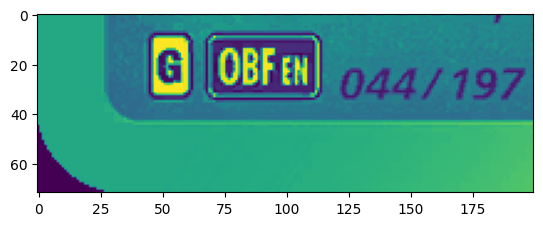

In [137]:
def ocr_text(img):
    img = preproc_clean(img).squeeze()
    tools = pyocr.get_available_tools()
    tool = tools[0]
    tool
    builder = pyocr.builders.TextBuilder(tesseract_layout=6)
    # builder.tesseract_configs.append("digits")
    builder.tesseract_configs.append("-c")
    builder.tesseract_configs.append("tessedit_char_whitelist=0123456789/")
    builder.tesseract_configs.append("--psm")
    builder.tesseract_configs.append("6")  # 0~13
    builder.tesseract_configs.append("--oem")
    builder.tesseract_configs.append("3")  # 0~3
    if isinstance(img, np.ndarray):
        img = Image.fromarray(img)
    result = tool.image_to_string(img, lang="eng", builder=builder)

    return result
img = augmented_df_left.loc[1000, 'corner']
print(ocr_text(img))
plt.imshow(img)

[ WARN:0@6067.661] global loadsave.cpp:248 findDecoder imread_('../../raw_data/swsh10-8.jpg_2'): can't open/read file: check file path/integrity


error: OpenCV(4.9.0) /Users/runner/work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


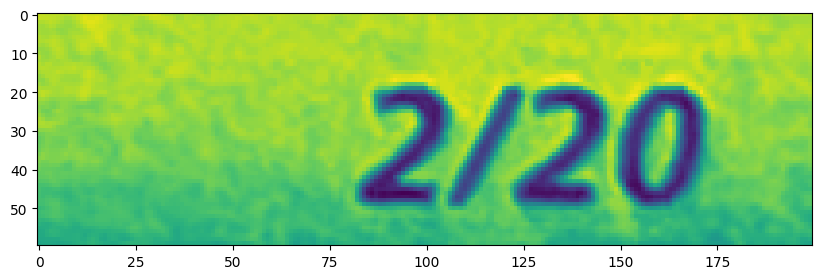

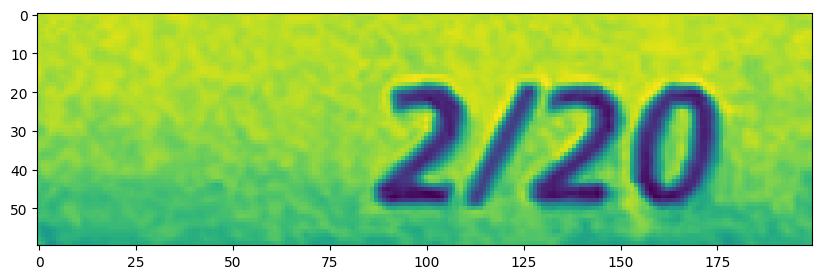

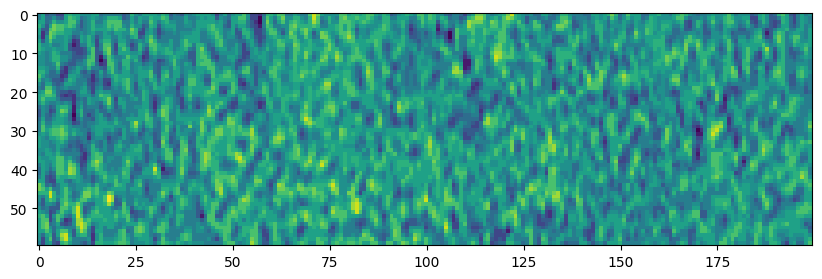

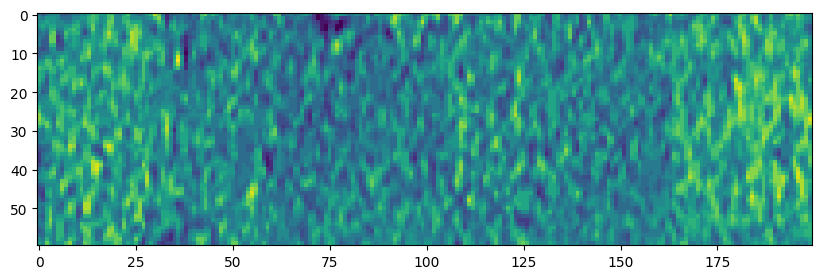

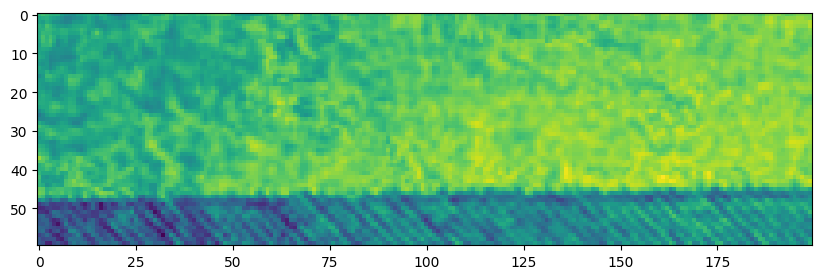

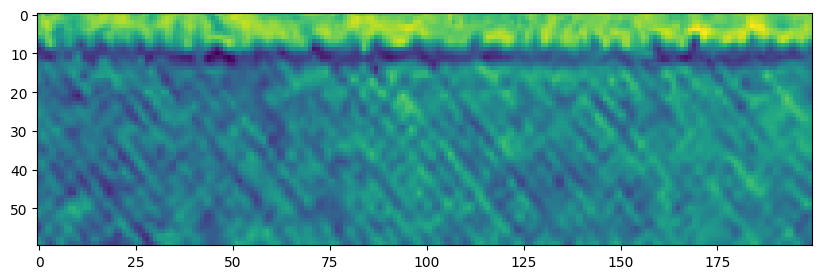

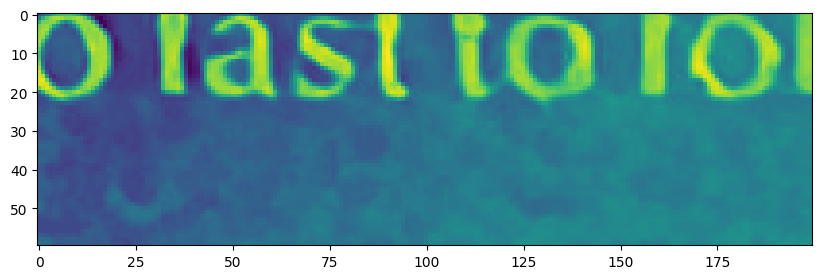

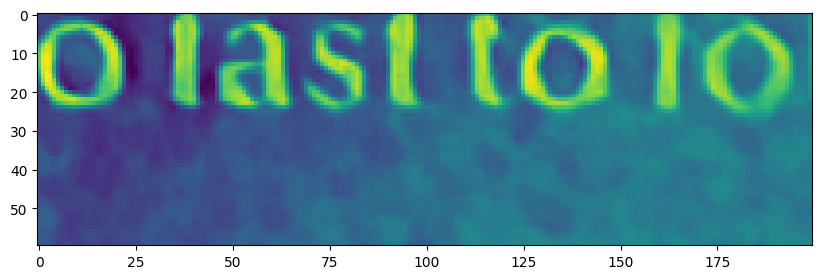

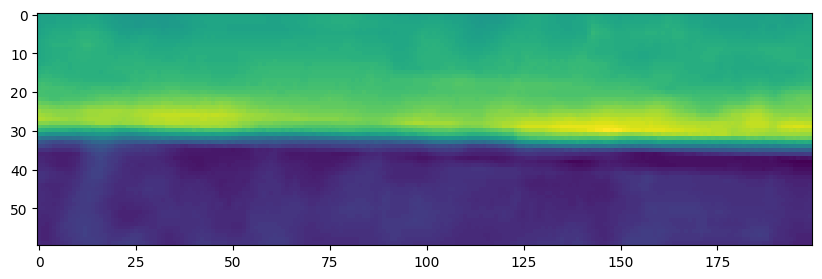

In [175]:
images = ['dv1-2.jpg','dv1-2_2.jpg','sm4-76.jpg','sm4-76_2.jpg','sv2-32.jpg','sv2-32_2.jpg','swsh10-45.jpg','swsh10-45_2.jpg','swsh10-8.jpg','swsh10-8.jpg_2','swsh12pt5-62.jpg','swsh45-11.jpg','swsh45-11_2.jpg','swsh6-16.jpg','swsh6-16_2.jpg','swsh9-81.jpg','swsh9-81_2.jpg','xy1-94.jpg','xy1-94_2.jpg']
i = 1
for img_name in images:
    set_id = 'dv1'
    image_path = f'../../raw_data/{img_name}'
    img = deform_card(image_path)
    bottomcorner = card_ocr_crop(img, set_id)
    preprocessed_img = ocr_preprocessor(bottomcorner,set_id)
    #im_text = get_pokeid(bottomcorner,set_id)
    plt.figure(figsize=(10,60))
    plt.subplot(10,1,i)
    i+=1
    plt.imshow(preprocessed_img)
    #plt.title(im_text)

In [270]:
images = ['dv1-2.jpg','dv1-2_2.jpg','sm4-76.jpg',
          'sm4-76_2.jpg','sv2-32.jpg','sv2-32_2.jpg',
          'swsh10-45.jpg','swsh10-45_2.jpg','swsh10-8.jpg',
          'swsh10-8_2.jpg','swsh12pt5-62.jpg','swsh45-11.jpg',
          'swsh45-11_2.jpg','swsh6-16.jpg','swsh6-16_2.jpg',
          'swsh9-81.jpg','swsh9-81_2.jpg','xy1-94.jpg',
          'xy1-94_2.jpg']

set_id = 'dp1'
#img_name = 'IMG_1486.jpg'
img_name = 'card_dp1_15.png'
image_path = f'../../raw_data/{img_name}'
img = deform_card(image_path)
#cropped = card_ocr_crop(img,set_id)
#plt.imshow(cropped)
img

No contour was found. Exiting.


In [268]:
get_pokeid(cropped,set_id)

4


'4'

In [247]:
preprocessed_img = ocr_preprocessor(cropped,set_id)
pokeid = ocr_text(preprocessed_img)
pokeid

''

In [ ]:
work on 9
work on 17 & 18


In [263]:
pokeid = '154130'
set_id = 'dp1'
clean_pokeid(pokeid,set_id)

'15'

/7



14/130
154130
16/130



20/130

22/130

24/130

26/130


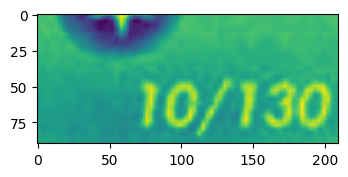

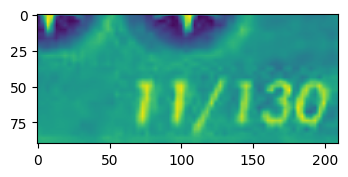

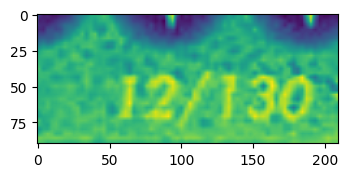

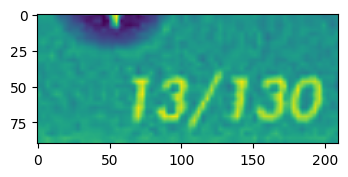

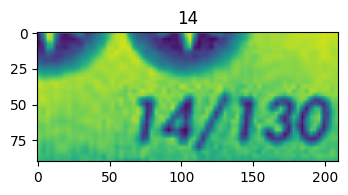

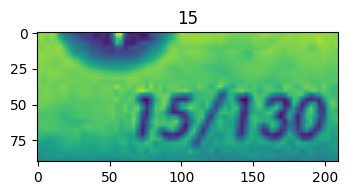

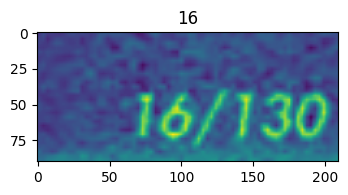

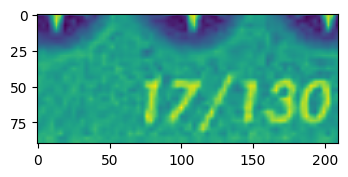

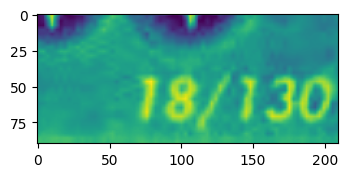

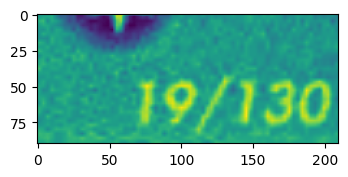

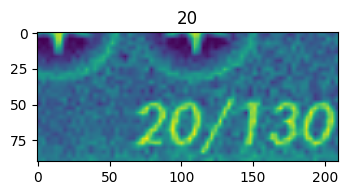

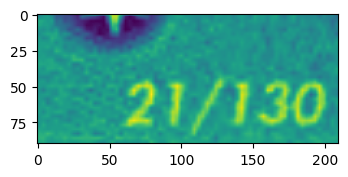

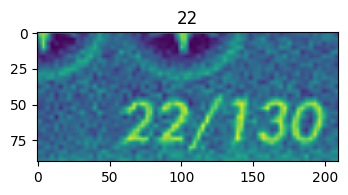

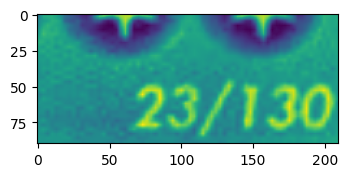

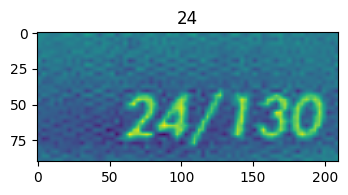

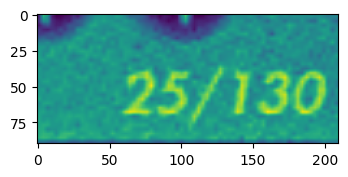

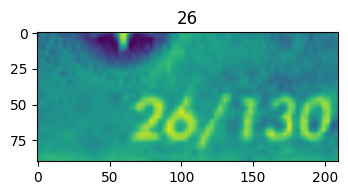

In [262]:
filepath = '../../raw_data/'
set_id = 'dp1' #
nb_cards = 30 #
for i in range(10,nb_cards+1):
    try:
        photo_path = f"{filepath}card_{set_id}_{i}.png"
        card = Image.open(photo_path)
        card_image = cv2.resize(np.array(card), (1800, 2475))
        bottomcorner = card_ocr_crop(card_image, set_id)
        preprocessed_img = ocr_preprocessor(bottomcorner,set_id)
        im_text = get_pokeid(bottomcorner,set_id)
        plt.figure(figsize=(10,60))
        plt.subplot(nb_cards,1,i)
        plt.imshow(preprocessed_img)
        plt.title(im_text)
    except:
        None